In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tskit, pyslim, msprime, tsconvert
import h5py
import re

In [3]:
B = 2
L = 1000000
file = '../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_1000000L_1.25e-08r_0.75f_%dn'
extra ='_25k_2.5e-08U'
ns = range(10)

# true dynamics

In [4]:
# truths
tss = [] #gens
Nss = [] #pop sizes
Ness = [] #effective sizes
pss = [] #allele freqs
for n in ns:
    filename = file %n + '.dynamics'
    dynamics = np.loadtxt(filename, skiprows=1) #truth during forward simulation (t,N,p)
    ts = dynamics[:,0]
    ts = dynamics[:,0][-1] - ts #convert forward time to backwards time
    tss.append(ts)
    Ns = [i*B for i in dynamics[:,1]] #multiply by B because SLiM records N before birth but we model census after
    Nss.append(Ns)
    Ness.append([i*4/(2+4*B-3) for i in Ns]) #effective popn size prediction
    ps = dynamics[:,2]
    pss.append(ps)

# infer effective population size

##  with relate

In [5]:
# relate
es = []
crs = []
for n in ns:
    filename = file %n + extra + '_popsize.coal'
    epochs = np.loadtxt(filename, skiprows=1, max_rows=1)
    es.append(epochs)
    coalrates = np.loadtxt(filename, skiprows=2)[2:] #note that the coal line starts with two 0s, indicating the popns being compared (https://myersgroup.github.io/relate/modules.html)
    if 0 in coalrates:
        print('inf Ne in %d' %n)
        coalrates = np.clip(coalrates,a_min=1e-8,a_max=None) #give some dummy small coalescence value
    crs.append(coalrates)

In [6]:
# recapitation
Ne = 1e4
Ne = 1e4*4/(2+4*B-3)
tsrs = []
Nsrs = []
for n in ns:
    tsr = np.array([tss[n][0], es[n][-1]]) #from "start" of forward simulation to end of inference
    tsrs.append(tsr)
    Nsr = np.array([Ne, Ne])
    Nsrs.append(Nsr)

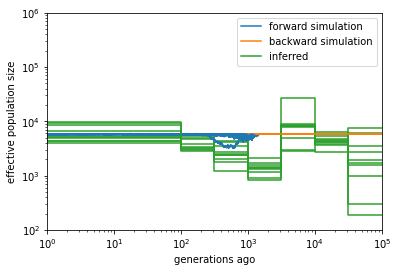

In [16]:
for n in ns:
    plt.step(tss[n], Ness[n], color = plt.cm.tab10(0))
    plt.step(tsrs[n], Nsrs[n], color = plt.cm.tab10(1))
    plt.step(es[n], 0.5/crs[n], where='post', color = plt.cm.tab10(2))

plt.xlabel('generations ago')
plt.ylabel('effective population size')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 1e5)
plt.ylim(1e2,1e6)
plt.legend(['forward simulation','backward simulation','inferred'])

figfile = file.replace('data','images') %len(ns) + extra + '.png'
plt.savefig(figfile)

plt.show()

# infer allele frequency dynamics with clues

##  with CLUES via true coalescence times and rates and popFreq

In [232]:
ctes = []
ctps = []
for n in ns:
    filename = file %n + extra + '_popsize_clues_true'
    try:
        freqs = np.load(filename + '.freqs.npy')
        clues_epochs = np.load(filename + '.epochs.npy')[:-1] #this is how clues plotting function loads the times (drops the last)
        ctes.append(clues_epochs)
        post = np.load(filename + '.post.npy')
        clues_ps = freqs[np.argmax(post, axis=0)] #maximum likelihood frequencies
        ctps.append(clues_ps)
    except:
        print('missing data for replicate %d' %n)
        ctes.append([])
        ctps.append([])

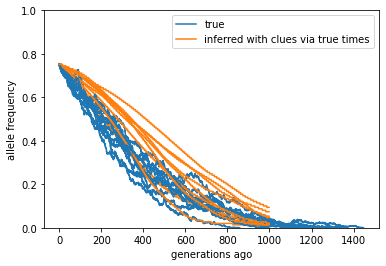

In [233]:
for n in ns:
    plt.step(tss[n], pss[n], color=plt.cm.tab10(0))
    plt.step(ctes[n], ctps[n], where='post', color=plt.cm.tab10(1))

plt.xlabel('generations ago')
plt.ylabel('allele frequency')
plt.ylim(0,1)
plt.legend(['true','inferred with clues via true times'])
plt.show()

## with CLUES via relate with true popFreq

and after running CLUES on the selected site we get this allele frequency

In [234]:
ces = []
cps = []
for n in ns:
    filename = file %n + extra + '_popsize_clues'
    try:
        freqs = np.load(filename + '.freqs.npy')
        clues_epochs = np.load(filename + '.epochs.npy')[:-1] #this is how clues plotting function loads the times (drops the last)
        ces.append(clues_epochs)
        post = np.load(filename + '.post.npy')
        clues_ps = freqs[np.argmax(post, axis=0)] #maximum likelihood frequencies
        cps.append(clues_ps)
    except:
        print('missing data for replicate %d' %n)
        ces.append([])
        cps.append([])

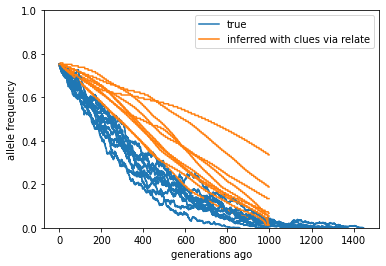

In [235]:
for n in ns:
    plt.step(tss[n], pss[n], color=plt.cm.tab10(0))
    plt.step(ces[n], cps[n], where='post', color=plt.cm.tab10(1))

plt.xlabel('generations ago')
plt.ylabel('allele frequency')
plt.ylim(0,1)
plt.legend(['true','inferred with clues via relate'])
plt.show()

why are some of these so far off?

i should look at the coalescence times to see if that is correlated with error here -- ie larger coalescnce times in derived lineages overestimates allele freq and underestaimtes s. i think it makes sense that relate is overestimateing coalescence times at selected sitres since it uses a neuitral prior

NOTE -- it looks from Stern et al 2019 fig 7 that CLUES can infer allele frequency trajectories well for selection coefficients as large as 0.03. But note that was CLUES-v0, which used ARGweaver trees. Now CLUES uses Relate trees, and Hejase et al 2022 show that CLUES is much worse than CLUES-v0 as it greatly understimates selection coefficients for selection coefficients even as large as 0.01. This is due to tree errors, as CLUES does well with true trees (as shown in that paper). This is also consistent with Brandt et al 2022, which shows that while both ARGweaver and Relate overestimate short coalescence times, Relate does so to a larger degree.

## with clues-v0 via argweaver with true popFreq

I'm now curious how ARGweaver trees would compare

In [237]:
caes = []
caps = []
for n in ns:
    filename = file %n + extra + '_argweaver/out.clues.h5'
    try:
        h5 = h5py.File(filename,'r')
        xs = h5.attrs['xHat']
        caps.append(xs)
        ts = h5.attrs['t'][:-1]
        caes.append(ts)
    except:
        print('missing data for replicate %d' %n)
        caps.append([])
        caes.append([])

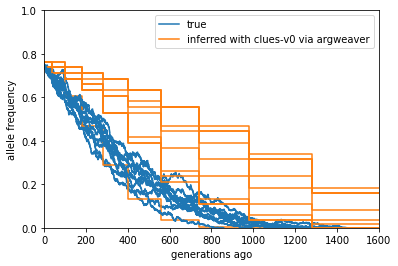

In [238]:
for n in ns:
    plt.step(tss[n], pss[n], color=plt.cm.tab10(0))
    plt.step(caes[n], caps[n], where='post', color=plt.cm.tab10(1))

plt.xlabel('generations ago')
plt.ylabel('allele frequency')
plt.xlim([0,1600])
plt.ylim(0,1)
plt.legend(['true','inferred with clues-v0 via argweaver'])
plt.show()

# selected tree

## truth

In [252]:
ts_true = tskit.load(file %0 + extra + '.trees' )
tree_true = ts_true.at(int(L/2))

In [260]:
[i for i in ts_true.sites() if i.position==L/2]

[Site(id=676, position=500000.0, ancestral_state='T', mutations=[Mutation(id=677, site=676, node=346, derived_state='C', parent=-1, metadata={'mutation_list': [{'mutation_type': 1, 'selection_coeff': 0.009999999776482582, 'subpopulation': 1, 'slim_time': 1, 'nucleotide': 1}]}, time=1276.0, edge=1502)], metadata=b'')]

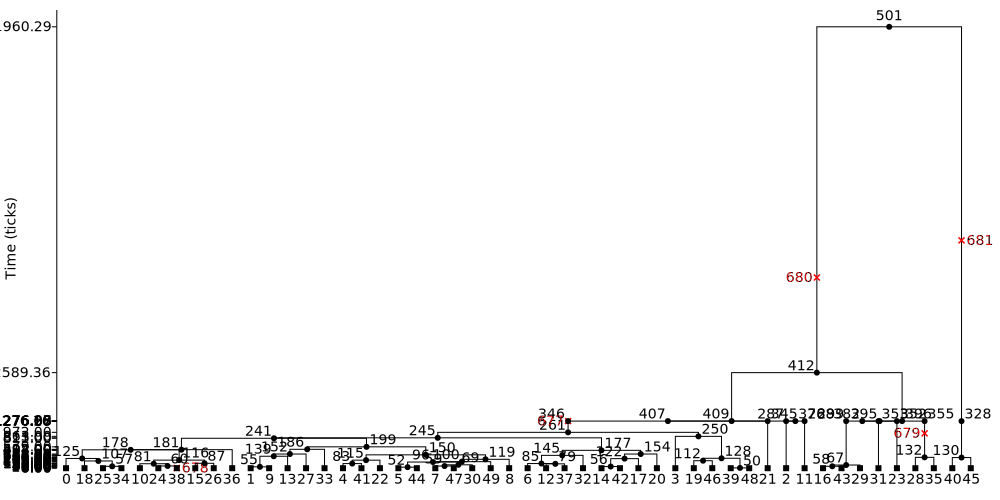

In [255]:
tree_true.draw_svg(size=(1e3,5e2), y_axis=True)

## relate

In [263]:
ts_relate = tskit.load(file %0 + extra + '_popsize.trees')
tree_relate = ts_relate.at(L/2)

In [264]:
[i for i in ts_relate.sites() if i.position==L/2]

[Site(id=675, position=500000.0, ancestral_state='T', mutations=[Mutation(id=675, site=675, node=2152, derived_state='C', parent=-1, metadata=b'', time=nan, edge=9311)], metadata=b'')]

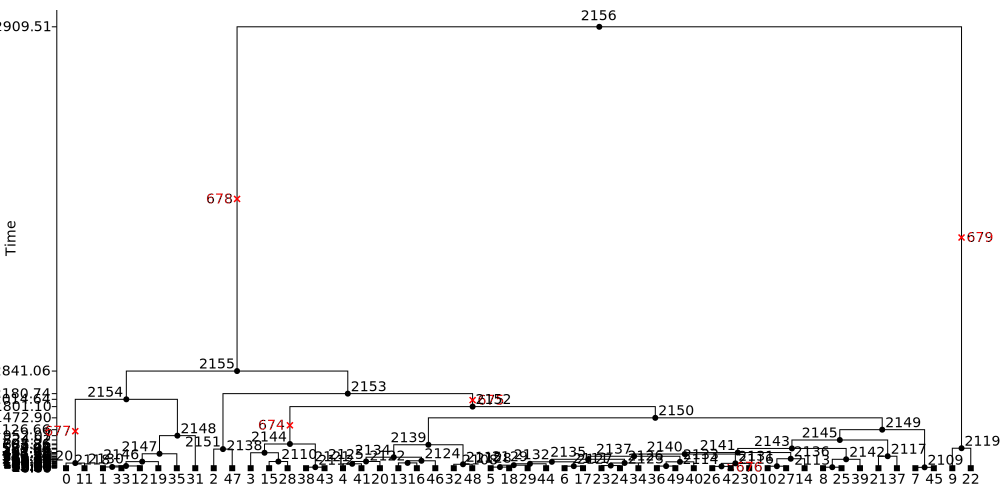

In [265]:
tree_relate.draw_svg(size=(1e3,5e2), y_axis=True)

## argweaver

In [266]:
treefile = file %0 + extra + '_argweaver/out.trees'
with open(treefile, 'r') as tf:
    for line in tf:
        last_tree = line.split()[-1]
argtree = re.sub("\[.*?\]","", last_tree) #reformat last tree, removing edge info which messes up conversion below
argts = tsconvert.from_newick(argtree, min_edge_length=1e-6) #discretization forces many coalescences at same time, so add dummy min_edge_length to satisfy tskit

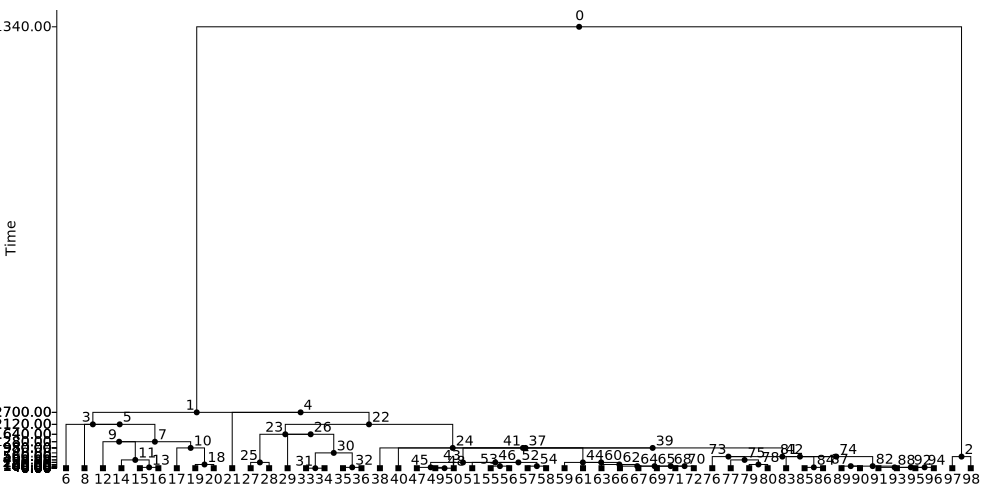

In [267]:
argts.first().draw_svg(size=(1e3,5e2), y_axis=True)

would be good to map mutation on to argweaver tree

## detect selection with relate

evidence of selection on all SNPs over time (log10 p values), https://myersgroup.github.io/relate/modules.html#Selection

In [268]:
seles= []
for n in ns:
    sele = np.loadtxt(file %n + extra + '_popsize.sele', skiprows=1)
    seles.append(sele)

pull out evidence of selection over all time (last column)

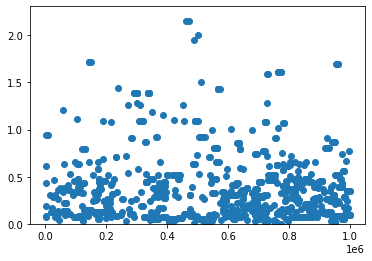

In [274]:
# for i in range(sele.shape[1]):
plt.scatter(seles[0][:,0],-seles[0][:,-1])
plt.ylim(0,None)
plt.show()

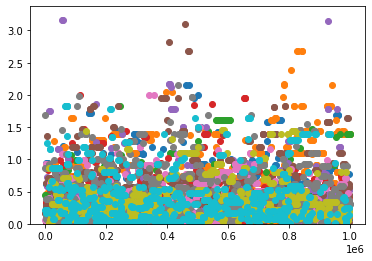

In [278]:
for sele in seles:
    plt.scatter(sele[:,0],-sele[:,-1])

plt.ylim(0,None)
plt.show()